<div class="alert alert-success">
    <h1>Assignment 1: Deep Learning</h1>
    <h3 align='center'>Computational Intelligence (4032-01)</h3>
    <h5 align='center'>Instructor: Dr.Samane Hosseini</h5>
    <h5 align='center'>TA: Arash Azhand</h5>
</div>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# 1. Generate Dataset

In [4]:
def load_moons_dataset():
    # TODO: Generate a dataset with make_moons (2000 samples, noise=0.3, random_state=42)

    # HINT:
    # 1. Use make_moons from sklearn.datasets.
    # 2. Convert X, y into PyTorch tensors of type torch.float32.
#1
    X, y = make_moons(n_samples=2000, noise=0.3, random_state=42)
#2
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

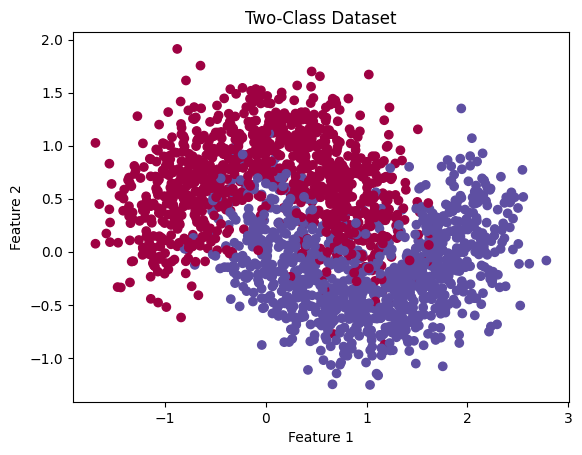

In [5]:
X, y = load_moons_dataset()

plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.Spectral)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two-Class Dataset")
plt.show()

**Desired Output:**

![image.png](attachment:a9922b19-aaa8-4489-839d-45c47a244dca.png)

# 2. Define Networks

In [6]:
# Define an underfitting model with one hidden layer and too few neurons (3 or 5)
class UnderfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(UnderfitNeuralNet, self).__init__()
        # TODO: Define a small neural network with just one hidden layer

        # HINT:
        # 1. First layer: input_dim → 3 neurons
        # 2. Output layer: 3 neurons → 1 neuron
        #1
        self.hidden = nn.Linear(input_dim, 3)
        #2
        self.output = nn.Linear(3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: Implement forward pass using ReLU and Sigmoid

        # HINT:
        # 1. Apply ReLU on the first layer.
        # 2. Apply Sigmoid on the final output layer.
#1
        x = self.hidden(x)
        x = self.relu(x)
  #2
        x = self.output(x)
        x = self.sigmoid(x)

        return x

In [7]:
# Define an overfitting model with more than 4 layers and too many neurons in each layer eg:(128, 64, 32)
class OverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(OverfitNeuralNet, self).__init__()
        # TODO: Define a deep neural network with multiple layers

        # HINT:
        # 1. First hidden layer: input_dim → 128 neurons
        # 2. Second hidden layer: 128 → 64 neurons
        # 3. Third hidden layer: 64 → 32 neurons
        # 3. Fourth hidden layer: 32 → 16 neurons
        # 4. Output layer: 16 → 1 neuron
        #1
        self.layer1 = nn.Linear(input_dim, 128)
        #2
        self.layer2 = nn.Linear(128, 64)
        #3
        self.layer3 = nn.Linear(64, 32)
        #4
        self.layer4 = nn.Linear(32, 16)
        #5
        self.output = nn.Linear(16, 1)
        #baraye tabeh baadi
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        # TODO: Implement forward pass using ReLU and Sigmoid

        # HINT:
        # 1. Apply ReLU on all hidden layers.
        # 2. Apply Sigmoid on the final output layer.
        #1
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        #2
        x = self.sigmoid(self.output(x))


        return x

# 3. Move data and models to CUDA (faster training with GPU)

In [8]:
# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=86)

# TODO: Move data to CUDA

# HINT:
# 1. Use `.to(device)` to move X_train, X_test, y_train, y_test to the same device.

# Example: X_train = X_train.to(device)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [10]:
# TODO: Move the instances of models to the specified device (GPU)
# Hint: You have already defined 'device' earlier.
# Use the `.to(device)` method to move both the underfit and overfit models to the same device as the data.
# Example:
# model = YourModelClass(...).to(device)


simple_model = UnderfitNeuralNet(input_dim=2).to(device)
complex_model = OverfitNeuralNet(input_dim=2).to(device)

In [11]:
# You can see a summary of yor model along with the number of parameters it has
%pip install torchsummary # !pip install torchsummary --> run this in google colab
from torchsummary import summary
print("Simple Model Summary:")
summary(simple_model, input_size=(2,))
print("Complex Model Summary:")
summary(complex_model, input_size=(2,))

Simple Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              ReLU-2                    [-1, 3]               0
            Linear-3                    [-1, 1]               4
           Sigmoid-4                    [-1, 1]               0
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Complex Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
      

Desired Output:

![image.png](attachment:image.png)

# 4. Train

In [12]:
def train(model, X_train, y_train, num_epochs=1000, batch_size=32, lr=0.01, lambda_reg=0.01, regularization_type=None):
    # TODO: Ensure the model is in training mode
    # This is necessary because some layers (like dropout or batch normalization) behave differently in training vs. evaluation mode.
    model.train()

    # TODO: Define the loss function
    # Hint: We are using Binary Cross Entropy (BCE) since this is a binary classification problem.
    criterion = nn.BCELoss()

    # TODO: Define the optimizer
    # Hint: Adam is used here, but you could experiment with other optimizers like SGD or RMSprop.
    optimizer = optim.Adam(model.parameters(), lr=lr)


    dataset = TensorDataset(X_train, y_train)
    # TensorDataset helps us manage input (X) and target (y) pairs in batches.

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # DataLoader splits the dataset into batches and shuffles them for better training performance.

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # TODO: Reset the gradients before backpropagation
            # Hint: PyTorch accumulates gradients by default, so we need to clear them at the start of each batch.
            optimizer.zero_grad()

            # TODO: Perform forward pass
            # Hint: Pass the input through the model to get predictions.
            outputs = model(inputs)

            # TODO: Compute the loss
            # Hint: Make sure the shapes match. if didn't match, you can use outputs.squeeze() which ensures it's the same shape as targets.
            loss = criterion(outputs.squeeze(), targets)

            batch_size_actual = inputs.size(0)
            # TODO: Implement L1 regularization if selected
            if regularization_type == "L1":
                l1_penalty = sum(p.abs().sum() for p in model.parameters() if p.requires_grad and p.dim() > 1)
                loss += (lambda_reg * l1_penalty) / batch_size_actual

            # TODO: Implement L2 regularization if selected
            elif regularization_type == "L2":
                l2_penalty = sum(p.pow(2).sum() for p in model.parameters() if p.requires_grad and p.dim() > 1)
                loss += (lambda_reg * l2_penalty) / batch_size_actual


            # TODO: Compute gradients using backpropagation
            # Hint: This step calculates how each weight should be updated.
            loss.backward()

            # TODO: Update model parameters
            # Hint: This applies the calculated gradients to update the model weights.
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        if epoch % 100 == 0:
            print(f"epoch {epoch}, loss: {running_loss}")

    return model

In [13]:
# NOTE: Do not make any changes here
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
    xx, yy = xx.to(device), yy.to(device)

    with torch.no_grad():
        Z = model(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)).cpu()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z.numpy(), levels=[0, 0.5, 1], alpha=0.6)
    plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu().numpy().flatten(), edgecolor='k')
    plt.title(title)
    plt.show()

# 5. Train Models with Different Configurations and Analyze Their Effects

### Experiment 1: Train the Models Without Regularization  (This is done for you)
- **Train both `UnderfitNeuralNet` and `OverfitNeuralNet` models without any regularization.**  
- **Hint:** Use the existing training function and evaluate their performance. Observe if the overfit model memorizes the training data.  

### Experiment 2: Apply L1 Regularization  
- **Modify the training to include L1 regularization.**  
- **Hint:** Add an L1 penalty term (`lambda_reg * sum(abs(param))`) to the loss function.  
- **Analyze:** Does it improve generalization? Do model weights become sparse?  

### Experiment 3: Apply L2 Regularization  
- **Modify the training function to include L2 regularization.**  
- **Hint:** Add an L2 penalty term (`lambda_reg * sum(param^2)`) to the loss function.  
- **Analyze:** Does it help reduce overfitting? Compare with the L1 model.  

### Experiment 4: Add Batch Normalization (for Overfitted Model)  
- **Modify the `OverfitNeuralNet` to include Batch Normalization layers. You can add more layers too.**  
- **Hint:** Use `nn.BatchNorm1d()` after fully connected layers.  
- **Analyze:** Does it stabilize training and improve performance?  

### Experiment 5: Add Dropout (for Overfitted Model) (EXTRA POINT)
- **Modify the `OverfitNeuralNet` to include Dropout layers.**  
- **Hint:** Use `nn.Dropout(p=0.5)` before activation functions.  
- **Analyze:** Does it help prevent overfitting? Compare decision boundaries.  

### Final Step: Compare and Interpret the Results  
- **Evaluate accuracy on test data for each experiment.**  
- **Plot the decision boundary for each model using the provided function.**  
- **Compare and discuss:**  
  - Which regularization method improved generalization the most?  
  - Did dropout or batch normalization help the overfitted model?  
  - How do underfitting and overfitting look in the plots?  

**Your goal:** Experiment, analyze, and understand how these techniques impact deep learning models!

In [14]:
print("Training too simple model without regularization...")
model_underfit = train(simple_model, X_train, y_train, regularization_type=None)
print("Training complicated model without regularization...")
model_overfit = train(complex_model, X_train, y_train, regularization_type=None)

Training too simple model without regularization...
epoch 0, loss: 883.842698097229
epoch 100, loss: 540.302737236023
epoch 200, loss: 537.2776107788086
epoch 300, loss: 538.8406271934509
epoch 400, loss: 537.2182455062866
epoch 500, loss: 536.4139289855957
epoch 600, loss: 536.0420017242432
epoch 700, loss: 536.2821164131165
epoch 800, loss: 535.9488325119019
epoch 900, loss: 535.5195622444153
Training complicated model without regularization...
epoch 0, loss: 570.4967606067657
epoch 100, loss: 306.59889960289
epoch 200, loss: 299.0933630466461
epoch 300, loss: 300.6207582950592
epoch 400, loss: 273.9081711769104
epoch 500, loss: 251.07588005065918
epoch 600, loss: 262.0915118455887
epoch 700, loss: 263.4113416671753
epoch 800, loss: 218.59148812294006
epoch 900, loss: 235.00027680397034


  **INTERPRETING RESULTS** is done in the last step but after the code of each experiment,there is some expalanation as an answer to questions in Analyze parts(The **MAIN ANALYZING** is done in the last step)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


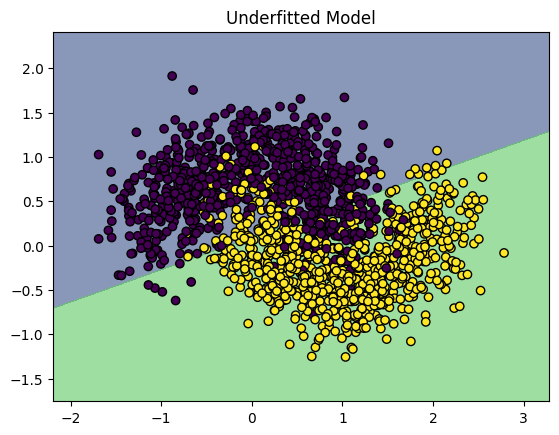

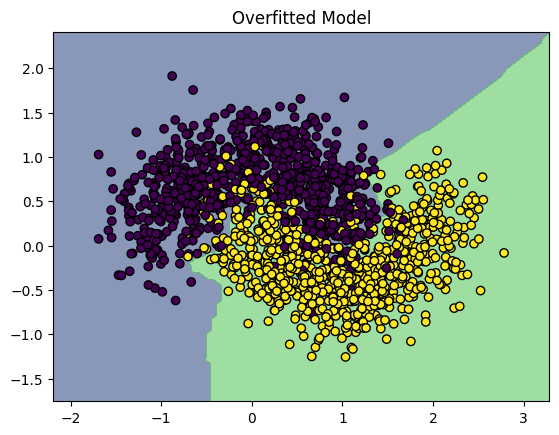

In [ ]:
plot_decision_boundary(X_train, y_train, model_underfit, title="Underfitted Model")
plot_decision_boundary(X_train, y_train, model_overfit, title="Overfitted Model")

In [ ]:
#اینکه لاس را به خاطر رگولاریزیشن باید تغییر بدهیم در مراحل قبلی که تابع اکوزش را نوشتیم لحاظ کردیم
#دو تا if
#برای این موضوع قرار دادیم در تابع train
print("Training too simple model with L1 regularization...")
model_underfit_l1 = train(simple_model, X_train, y_train, regularization_type="L1")
print("Training complicated model with l1 regularization...")
model_overfit_l1 = train(complex_model, X_train, y_train, regularization_type="L1")

Training too simple model with L1 regularization...
epoch 0, loss: 543.0227890014648
epoch 100, loss: 542.8752574920654
epoch 200, loss: 542.4934973716736
epoch 300, loss: 545.5817723274231
epoch 400, loss: 541.2332017421722
epoch 500, loss: 543.2761392593384
epoch 600, loss: 540.2199425697327
epoch 700, loss: 542.2512629032135
epoch 800, loss: 541.6348271369934
epoch 900, loss: 540.2081642150879
Training complicated model with l1 regularization...
epoch 0, loss: 2547.5799522399902
epoch 100, loss: 466.38981771469116
epoch 200, loss: 403.33151149749756
epoch 300, loss: 379.75266313552856
epoch 400, loss: 361.9358355998993
epoch 500, loss: 365.4565510749817
epoch 600, loss: 353.2602972984314
epoch 700, loss: 354.82790660858154
epoch 800, loss: 344.09848713874817
epoch 900, loss: 344.0834791660309


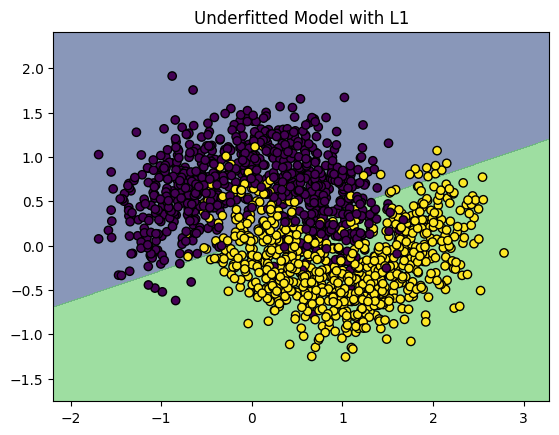

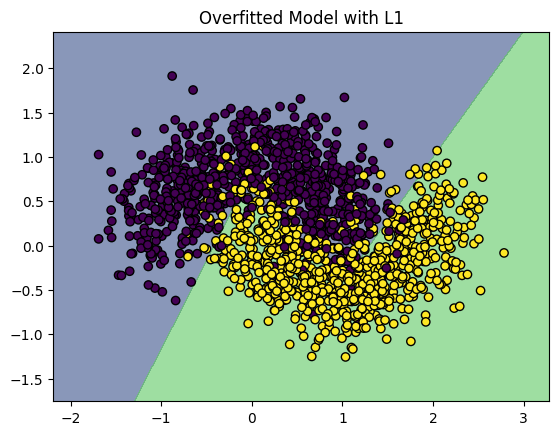

In [ ]:
plot_decision_boundary(X_train, y_train, model_underfit_l1, title="Underfitted Model with L1")
plot_decision_boundary(X_train, y_train, model_overfit_l1, title="Overfitted Model with L1")

1. Improves Generalization

L1 regularization adds a penalty term to the loss function:
Loss=Original Loss+λ∑∣wi∣
Loss=Original Loss+λ∑∣wi​∣

This discourages the model from relying too heavily on any single feature by shrinking less important weights — which reduces overfitting, especially on noisy or high-dimensional datasets.

2. Encourages Sparsity

Unlike L2 (which shrinks weights but rarely makes them exactly zero), L1 tends to push some weights to exactly zero, effectively performing feature selection. This is especially useful when:

  You have many irrelevant features.
  
  You want a compact, interpretable model.

In [ ]:

print("Training too simple model with L2 regularization...")
model_underfit_l2 = train(simple_model, X_train, y_train, regularization_type="L2")
print("Training complicated model with l2 regularization...")
model_overfit_l2 = train(complex_model, X_train, y_train, regularization_type="L2")

Training too simple model with L2 regularization...
epoch 0, loss: 541.5052213668823
epoch 100, loss: 500.87109088897705
epoch 200, loss: 504.6262879371643
epoch 300, loss: 500.8518137931824
epoch 400, loss: 502.67903423309326
epoch 500, loss: 500.69885778427124
epoch 600, loss: 500.9109320640564
epoch 700, loss: 501.8958444595337
epoch 800, loss: 502.21203804016113
epoch 900, loss: 499.31155014038086
Training complicated model with l2 regularization...
epoch 0, loss: 432.05292892456055
epoch 100, loss: 353.01478242874146
epoch 200, loss: 348.4423243999481
epoch 300, loss: 347.2398929595947
epoch 400, loss: 355.0634973049164
epoch 500, loss: 351.31455659866333
epoch 600, loss: 349.5996904373169
epoch 700, loss: 349.4940673112869
epoch 800, loss: 358.333455324173
epoch 900, loss: 344.6773998737335


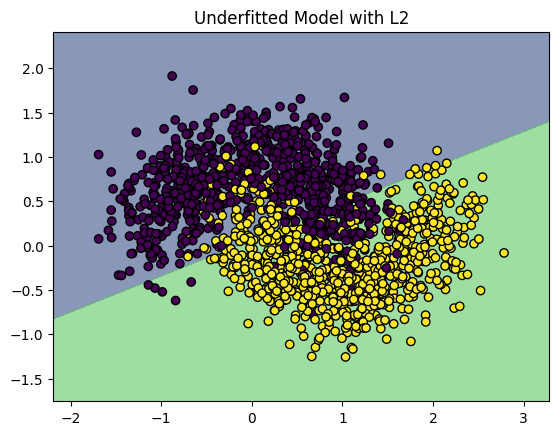

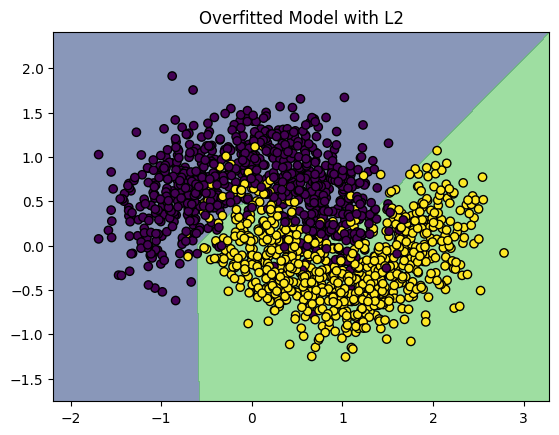

In [ ]:
plot_decision_boundary(X_train, y_train, model_underfit_l2, title="Underfitted Model with L2")
plot_decision_boundary(X_train, y_train, model_overfit_l2, title="Overfitted Model with L2")

L2 regularization does help reduce overfitting, but it works differently than L1 regularization :

L2 Regularization (a.k.a. weight decay):

What it does: Penalizes large weights by adding λ * sum(weights^2) to the loss function.

Effect:

  1.Makes weights small but non-zero.

  2.Encourages the model to spread out information across all features.

  3.Helps with overfitting by smoothing the model without enforcing sparsity.


L1 Regularization

 What it does: Adds λ * sum(|weights|) to the loss.

 Effect:

 1.Encourages weights to become exactly zero, leading to sparse models.

  2.Works as an implicit feature selection method.

  3.Good when you expect many input features to be irrelevant.

In [ ]:
#OverfitNeuralNet with batch normalization
class OverfitNeuralNetBN(nn.Module):
    def __init__(self, input_dim):
        super(OverfitNeuralNetBN, self).__init__()

        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.layer4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)

        self.output = nn.Linear(16, 1)


        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.relu(self.bn4(self.layer4(x)))
        x = self.sigmoid(self.output(x))
        return x


In [ ]:
complex_model_with_BN = OverfitNeuralNetBN(input_dim=2).to(device)
print("Training complicated model with batch normalization")
model_overfit_BN = train(complex_model_with_BN, X_train, y_train, regularization_type=None)

Training complicated model with batch normalization
epoch 0, loss: 526.9424691200256
epoch 100, loss: 412.4814660549164
epoch 200, loss: 413.52550053596497
epoch 300, loss: 384.2264425754547
epoch 400, loss: 406.83885073661804
epoch 500, loss: 378.3974401950836
epoch 600, loss: 362.56177258491516
epoch 700, loss: 361.6417238712311
epoch 800, loss: 382.249881029129
epoch 900, loss: 375.5638039112091


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


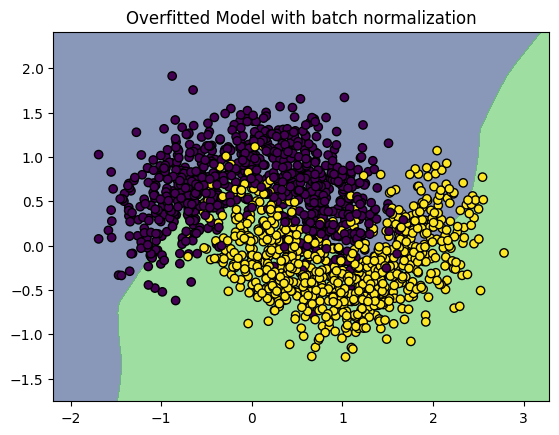

In [ ]:
plot_decision_boundary(X_train, y_train, model_overfit_BN, title="Overfitted Model with batch normalization")

batch normalization both stabilizes training and often improves performance.

1.Stabilizes training:By normalizing the inputs to each layer (zero mean, unit variance), the network becomes less sensitive to parameter initialization and learns more smoothly.

2.Allows higher learning rates:Since the training is more stable, you can safely increase the learning rate, which can speed up convergence.

3.Acts as a form of regularization:Because the mean and variance are computed over mini-batches, there's some noise in the input statistics — this introduces a regularizing effect, reducing overfitting.

In [15]:

class OverfitNeuralNetWithDropOut(nn.Module):
    def __init__(self, input_dim):
        super(OverfitNeuralNetWithDropOut, self).__init__()

        self.layer1 = nn.Linear(input_dim, 128)

        self.layer2 = nn.Linear(128, 64)

        self.layer3 = nn.Linear(64, 32)

        self.layer4 = nn.Linear(32, 16)

        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


        self.dropout1=nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.3)


    def forward(self, x):
        x = self.dropout1(self.relu(self.layer1(x)))
        x = self.dropout2(self.relu(self.layer2(x)))
        x = self.dropout3(self.relu(self.layer3(x)))
        x = self.relu(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x


In [16]:
complex_model_with_dropout = OverfitNeuralNetWithDropOut(input_dim=2).to(device)
print("Training complicated model with drop out")
model_overfit_dr = train(complex_model_with_dropout, X_train, y_train, regularization_type=None)

Training complicated model with drop out
epoch 0, loss: 662.438823223114
epoch 100, loss: 360.20727372169495
epoch 200, loss: 356.17641711235046
epoch 300, loss: 344.03180146217346
epoch 400, loss: 353.1099286079407
epoch 500, loss: 361.85500502586365
epoch 600, loss: 348.97240817546844
epoch 700, loss: 354.42055678367615
epoch 800, loss: 367.7720685005188
epoch 900, loss: 363.64295744895935


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


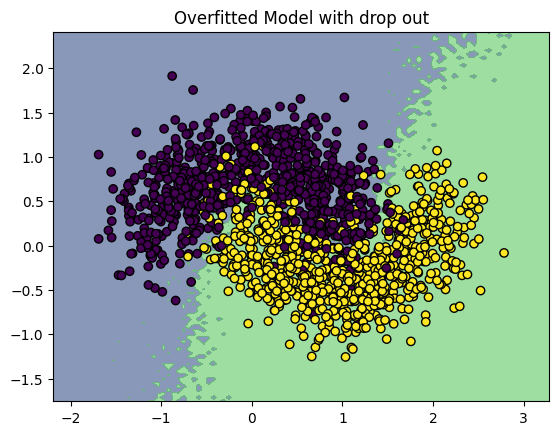

In [17]:
plot_decision_boundary(X_train, y_train, model_overfit_dr, title="Overfitted Model with drop out")

Dropout helps prevent overfitting by randomly deactivating a subset of neurons during training.It mainly forces the model to not rely too heavily on specific neurons. This encourages redundancy and robustness, which improves generalization on unseen data.

If you compare the decision boundary of an overfitted model with the decision boundary of an overfitted model with dropout:
The **overfitted model**'s decision boundary will likely be **very complex**, possibly **zigzagging** around the training data points, trying to fit every small variation in the data. This is a classic sign of overfitting, where the model has memorized the noise in the data and doesn’t generalize well to new, unseen data.

The model with dropout (even though it’s also overfitting) will have a more **simplified and smoother decision** boundary compared to the first one. Dropout prevents certain neurons from being active during each training step, forcing the model to not rely on specific features too much. As a result, the decision boundary might still be imperfect, but it will be **less erratic and more generalized**. The boundary might appear **a bit fuzzier and noisier** especially **around boundry area **compared to the overfitted model because dropout introduces randomness during training, making the model more robust.


In [ ]:
# Function to evaluate the model on test data
# def evaluate_model(model, X_test, y_test, criterion):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         outputs = model(X_test).squeeze()
#         loss = criterion(outputs, y_test.squeeze())
#         predictions = (outputs > 0.5).float()  # Convert logits to binary labels
#         accuracy = (predictions == y_test).float().mean()

#     print(f"Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item() * 100:.2f}%")
#     return loss.item(), accuracy.item()
# change the evaluate_model class to evaluate models with l1 or l2 regularization or none of them too(works for all experimants)
def evaluate_model(model, X_test, y_test, criterion,
                   l1_lambda=0.0, l2_lambda=0.0):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test).squeeze()
        base_loss = criterion(outputs, y_test.squeeze())

        l1_loss = 0.0
        l2_loss = 0.0

        # Loop through all model parameters
        for param in model.parameters():
            if l1_lambda > 0:
                l1_loss += torch.sum(torch.abs(param))
            if l2_lambda > 0:
                l2_loss += torch.sum(param ** 2)

        total_loss = base_loss + l1_lambda * l1_loss + l2_lambda * l2_loss

        predictions = (outputs > 0.5).float()
        accuracy = (predictions == y_test).float().mean()

    print(f"Test Loss: {total_loss.item():.4f}, Test Accuracy: {accuracy.item() * 100:.4f}%")
    return total_loss.item(), accuracy.item()


Test Loss: 0.2835, Test Accuracy: 88.0000%
Test Loss: 0.2508, Test Accuracy: 89.2500%


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


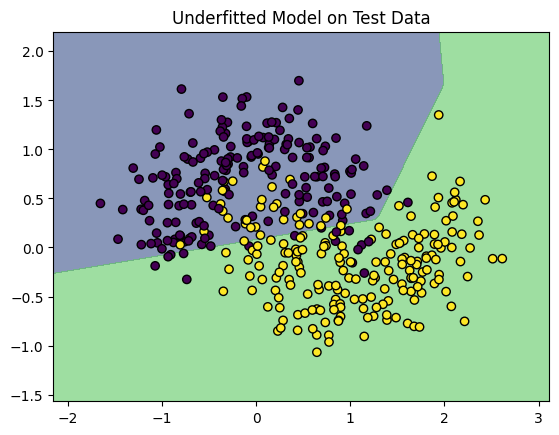

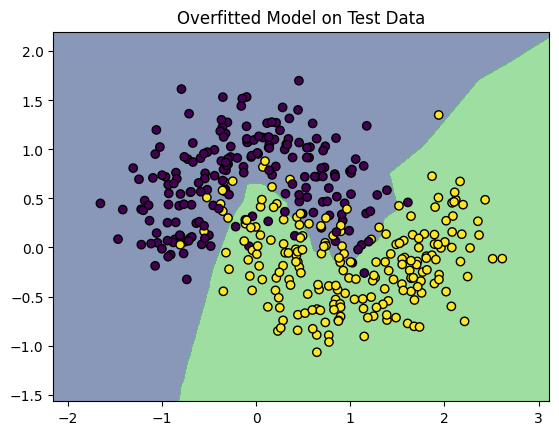

In [ ]:
# Evaluate on Test Data
evaluate_model(model_underfit, X_test, y_test, nn.BCELoss())
evaluate_model(model_overfit, X_test, y_test, nn.BCELoss())

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, model_underfit, title="Underfitted Model on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit, title="Overfitted Model on Test Data")

Test Loss: 0.3049, Test Accuracy: 88.0000%
Test Loss: 0.5710, Test Accuracy: 89.2500%


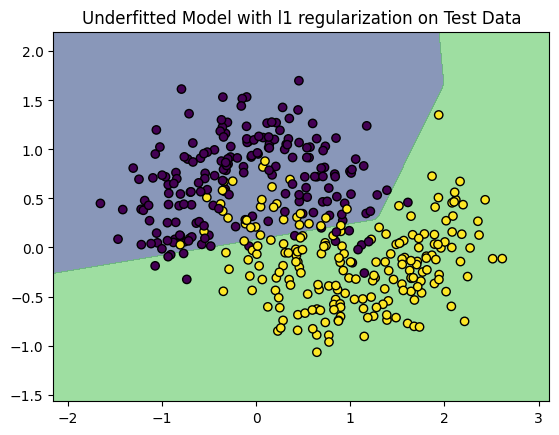

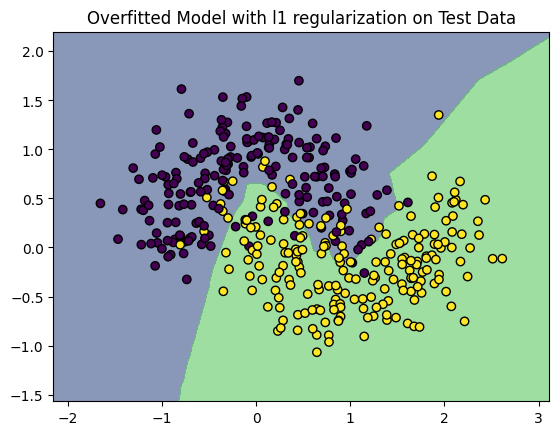

In [ ]:
evaluate_model(model_underfit_l1, X_test, y_test, nn.BCELoss(),l1_lambda=1e-3)
evaluate_model(model_overfit_l1, X_test, y_test, nn.BCELoss(),l1_lambda=1e-3)

plot_decision_boundary(X_test, y_test, model_underfit_l1, title="Underfitted Model with l1 regularization on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit_l1, title="Overfitted Model with l1 regularization on Test Data")

Test Loss: 0.2900, Test Accuracy: 88.0000%
Test Loss: 0.3044, Test Accuracy: 89.2500%


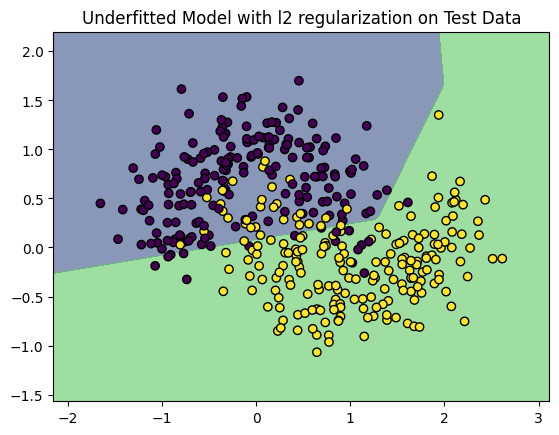

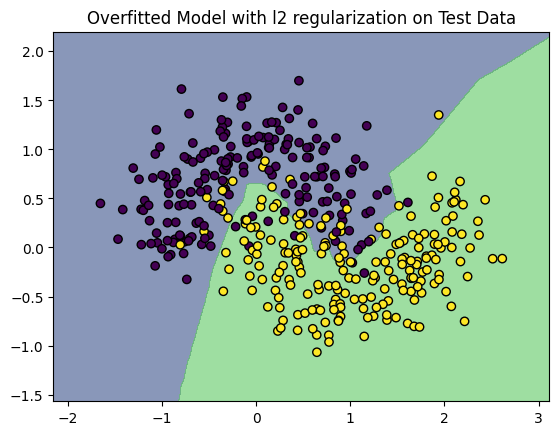

In [ ]:
evaluate_model(model_underfit_l2, X_test, y_test, nn.BCELoss(),l2_lambda=1e-4)
evaluate_model(model_overfit_l2, X_test, y_test, nn.BCELoss(),l2_lambda=1e-4)

plot_decision_boundary(X_test, y_test, model_underfit_l2, title="Underfitted Model with l2 regularization on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit_l2, title="Overfitted Model with l2 regularization on Test Data")

**As you can see from accuracy scores and decision boundry plots,for overfitted model there is no difference (that you can notice) and it is the same for underfitted model which could be because of simplicity of the dataset.**

Both L1 and L2 regularization are used to reduce overfitting and improve generalization, but L2 regularization generally improves generalization more consistently, especially in deep learning and most machine learning models.

  **L2** regularization (also called weight decay) works by penalizing large weights, encouraging the model to keep all weights small and smooth. This helps prevent overfitting by reducing the model’s complexity in a continuous way.

  **L1** regularization, on the other hand, tends to push many weights exactly to zero. This leads to sparse models, which is helpful when you want feature selection or when only a few features are truly important.

In practice, L2 is more commonly used and more effective for improving generalization, especially when you are not explicitly aiming for sparsity.




**What is expected If You Use L1 or L2 Regularization on an Underfitted Model?**

If your model is already underfitting (i.e., it can't even perform well on the training set), adding L1 or L2 regularization will usually make the problem worse.

  Because egularization adds a constraint that limits how much the model can "learn" from the data. If the model is already too simple or not learning enough, regularization will further restrict it.

  The test accuracy in such a case is likely to decrease, because you're weakening an already weak model even more. The model won’t generalize better — it will just perform poorly on both training and test data.


Test Loss: 0.2250, Test Accuracy: 91.5000%


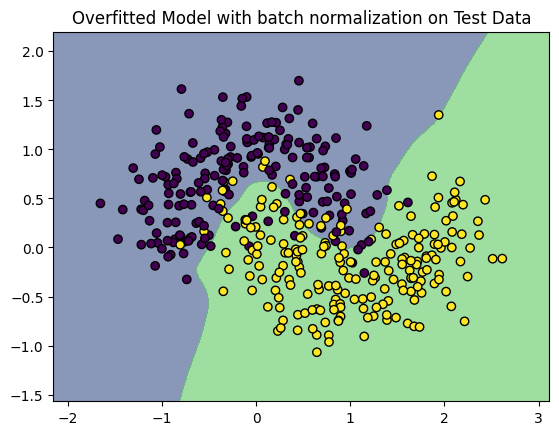

In [ ]:
evaluate_model(model_overfit_BN, X_test, y_test, nn.BCELoss())

plot_decision_boundary(X_test, y_test, model_overfit_BN, title="Overfitted Model with batch normalization on Test Data")

Test Loss: 0.2215, Test Accuracy: 91.2500%


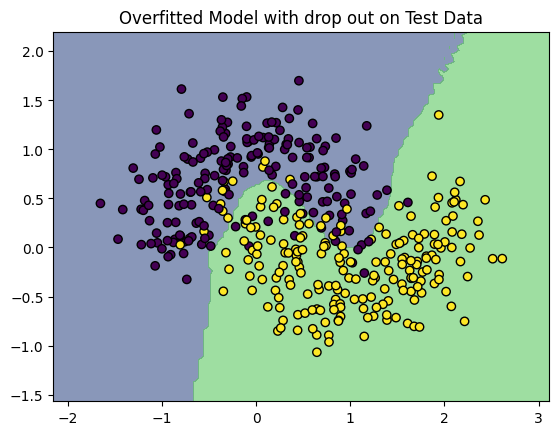

In [ ]:
evaluate_model(model_overfit_dr, X_test, y_test, nn.BCELoss())

plot_decision_boundary(X_test, y_test, model_overfit_dr, title="Overfitted Model with drop out on Test Data")

**As you can see,dropout and batch normalization both helped the overfitted model and increased the test accuracy.**
drop out:89.25 to 91.25
batch normalization:89.25 to 91.5
At first i tried the overfitted model with l2 regularization with drop out and batch normalization but in that scenario when i checked test accuracy there was not much difference.



expalanation about these two techniques have been delivered in previous parts

**How do underfitting and overfitting look in the plots?**

**Underfitting (High Bias):**

  The decision boundary is too simple or too smooth.

  It fails to capture the actual pattern of the data.

  You'll see many training points misclassified, even if they’re well-separated.

**Often looks like a straight line or gently curved surface, ignoring the complexity in the data.**

Visual example:

**A linear line separating classes that are clearly non-linearly separable like spirals or circles.**

**Overfitting (High Variance):**

  The decision boundary is overly complex and wiggly, trying to perfectly separate the training data.

  It often bends sharply around individual training points, even noisy ones.

  **The boundary may look irregular and fragile, with sharp corners or tiny loops**.

  While it may classify all training points correctly, it generalizes poorly to new/unseen data.

Visual example :

  **A tangled curve that wraps around every single point of one class while avoiding the others.**